In [25]:
import re
import glob
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [14]:
files = glob.glob("dados/*.json")

In [3]:
graphs = dict()
for filename in files:
    DG = nx.DiGraph()
    with open(filename, 'r', encoding="utf8") as f: 
        data = json.load(f)
        for tweet in data:
            DG.add_node(tweet)
            if(data[tweet]['replie_to'] is not None):
                DG.add_node(data[tweet]['replie_to'])
                DG.add_edge(tweet,data[tweet]['replie_to'])
            for attr in data[tweet]:
                DG.node[tweet][attr] = data[tweet][attr]
    graphs[filename] = DG

In [4]:
analyser = SentimentIntensityAnalyzer()

In [5]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [32]:
g = Digraph('G')
g.attr(size='20')
with open("dados/replies_238717783007977473.json", 'r', encoding="utf8") as f:
    data = json.load(f)
g.attr('node')
for key in data:
    score = sentiment_analyzer_scores(data[key]["text"])
    print(key, " ", score['compound'])
    if(score['compound'] <= -0.8):
        g.node(key, color='#67001F', style="filled")
    elif(score['compound'] > -0.8 and score['compound'] <= -0.6):
        g.node(key, color='#B2172B', style="filled")
    elif(score['compound'] > -0.6 and score['compound'] <= -0.4):
        g.node(key, color='#D6604D', style="filled")
    elif(score['compound'] > -0.4 and score['compound'] <= -0.2):
        g.node(key, color='#F4A582', style="filled")
    elif(score['compound'] > -0.2 and score['compound'] < 0):
        g.node(key, color='#FDDBC7', style="filled")
    elif(score['compound'] == 0.0):
        g.node(key, color='#F8F8F8', style="filled")
    elif(score['compound'] > 0.0 and score['compound'] <= 0.2):
        g.node(key, color='#D1E5F0', style="filled")
    elif(score['compound'] > 0.2 and score['compound'] <= 0.4):
        g.node(key, color='#92C5DF', style="filled")
    elif(score['compound'] > 0.4 and score['compound'] <= 0.6):
        g.node(key, color='#4393C3', style="filled")
    elif(score['compound'] > 0.6 and score['compound'] <= 0.8):
        g.node(key, color='#2166AC', style="filled")
    elif(score['compound'] > 0.8):
        g.node(key, color='#053061', style="filled")
for key in data:
    if(key is not None):
        if(data[key]["replie_to"] is not None):
            g.edge(data[key]["replie_to"], key)
g.view()

238717783007977473   0.3182
238718801343049728   0.6597
238719202263965696   -0.5106
947501808855011328   0.3404
759346872628772864   0.0
238718121823846400   -0.5574
238726229736448000   0.5574
641251809173049344   0.0
238719458884067328   -0.4404
1112491851909468162   0.4199
1122636810348376064   0.0
238727438090248192   0.1779
238724090653986816   -0.8391
238723796830416897   -0.6486
238718509801156608   0.1531
238774921176686592   -0.7613
844592765187035136   -0.2023
238718590780571650   -0.4767
238786423862476801   -0.7783
238745462625148928   -0.6908
238725270679453696   -0.2732
238826903585296384   0.3182
238760807800897538   -0.7783
238740911859843072   0.3182
238731766733619200   -0.3535
822195639836639233   0.501
238719435521789952   0.3802
818913584528781314   0.0
732228132443426818   0.34
238743891300462592   -0.7579
238728896915316736   0.0
238727919734755328   -0.6249
238720917700763649   0.0
238724598521282561   0.8439
1121843229698088960   0.0
1120792806589521920   0.0


'G.gv.pdf'

In [29]:
files2 = glob.glob("dados/replies_238717783007977473_*.json")

In [30]:
plotar = list()
for tree in files2:
    with open(tree, 'r', encoding="utf8") as f:
        data = json.load(f)
        aux = list()
        for tweet in data:
            score = sentiment_analyzer_scores(data[tweet]["text"])
            aux.append(score['compound'])
    plotar.append(np.array(aux))

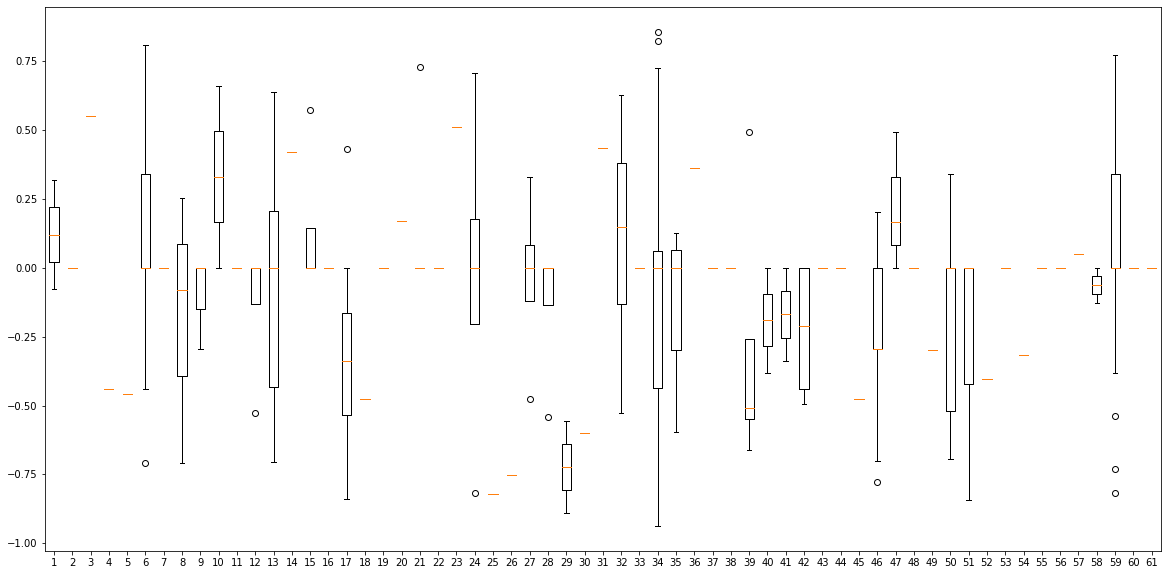

In [31]:
# Create a figure instance
fig = plt.figure(1, figsize=(20, 10))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(plotar)

# Save the figure
_= plt.savefig("dist_sentiment.png", quality = 95, orientation='portrait')